<a href="https://colab.research.google.com/github/Neo-glitch/kaggle_competitions/blob/main/Kaggle_Titanic_Dataset_Competition(80_kaggle_score).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, \
                                    GridSearchCV, RandomizedSearchCV,train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, OrdinalEncoder,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# using sklearn-pandas package
from sklearn_pandas import CategoricalImputer
from sklearn.impute import SimpleImputer

# too reduce dim of features
from sklearn.decomposition import PCA

## Load data from Kaggle

In [3]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"princeneo","key":"3b9d7386bd779e976792802bc36ea840"}'}

In [4]:
# make a kaggle dir
!mkdir ~/.kaggle

# copies kaggle json to kaggle dir
!cp kaggle.json ~/.kaggle/

# gives permission
! chmod 600 ~/.kaggle/kaggle.json


# copied api command to get kaggle dataset
! kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 18.7MB/s]


In [5]:
# make titanic dir
!mkdir titanic

!unzip titanic -d titanic

Archive:  titanic.zip
  inflating: titanic/gender_submission.csv  
  inflating: titanic/test.csv        
  inflating: titanic/train.csv       


In [166]:
train_df = pd.read_csv("/content/titanic/train.csv")

test_df = pd.read_csv("/content/titanic/test.csv")

submission_df = pd.read_csv("/content/titanic/gender_submission.csv")

train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


* survival (Survival) =>	0 = No, 1 = Yes
* pclass  	Ticket class => 	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	(Sex) => Male , Female
* Age	(Age in years	)
* sibsp	(# of siblings / spouses aboard the Titanic	)
* parch	(# of parents / children aboard the Titanic	)
* ticket	Ticket number	
* fare	(Passenger fare	)
* cabin	(Cabin number	)
* embarked	(Port of Embarkation) =>	C = Cherbourg, Q = Queenstown, S = Southampton

In [167]:
# helper to drop col
def drop_column(dataframe, column_list):
    new_df = dataframe.drop(columns = column_list)
    return new_df

# helper to get metrics and store in a dict
# def get_model_score_and_save(y_test, y_pred, clf_name, result_dict):
#     score_dict = {}
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average="macro")
#     recall = recall_score(y_test, y_pred, average="macro")
#     f1 = f1_score(y_test, y_pred, average="macro")
    
#     score_dict["accuracy"] = accuracy
#     score_dict["precision"] = precision
#     score_dict["recall"] = recall
#     score_dict["f1_score"] = f1
    
#     result_dict[clf_name] = score_dict

### Handling nan values

In [168]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [169]:
train_df.isnull().sum() # cabin col has a lot of missing values making it a not so good feature

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [170]:
train_data = train_df.copy()

train_data = drop_column(train_data, ["Cabin"])

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [171]:
# we could have just replaced the age col with mean values, but we can missing values are just to large to do this.
# we could just use a person's name title and Sex to accertain this


# get the title first
train_data["Title"] = train_data["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())

# fill age with mean based on sex and title
train_data["Age"] = train_data["Age"].fillna(train_data.groupby(["Sex", "Title"])["Age"].transform('mean'))

In [172]:
# fill embark col with mot frequent
imputer = CategoricalImputer()
train_data["Embarked"] = imputer.fit_transform(train_data["Embarked"])


train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [173]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

### Extracting Features

In [174]:
train_data["Ticket"].head(5)  # we can see that the ticket is alpaha numeric

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [175]:
otherwise = train_data["Ticket"].str.split(" ").str.get(0).str.get(0)  # gets the first char
train_data["Ticket_type"] = np.where(train_data["Ticket"].str.isdigit(), "N", otherwise)

train_data["Ticket_type"].value_counts()

N    661
P     65
S     65
C     47
A     29
W     13
F      7
L      4
Name: Ticket_type, dtype: int64

In [176]:
# group lower occuring frequency tickets, together to reduce dim when doing one hot encodings
train_data["Ticket_type"] = train_data["Ticket_type"].apply(lambda x: "AFWL" if x in "AFWL" else x)

train_data.groupby("Ticket_type").count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
Ticket_type,,,,,,,,,,,,
AFWL,53,53,53,53,53,53,53,53,53,53,53,53
C,47,47,47,47,47,47,47,47,47,47,47,47
N,661,661,661,661,661,661,661,661,661,661,661,661
P,65,65,65,65,65,65,65,65,65,65,65,65
S,65,65,65,65,65,65,65,65,65,65,65,65


In [177]:
# time to do same with title col with aim of having just 5 bins

train_data["Title"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [178]:
# to get more insight about what a title might mean
train_data.groupby(["Title", "Sex"]).count()

PassengerId  Survived  Pclass  Name  Age  SibSp  Parch  \
Title        Sex                                                              
Capt         male              1         1       1     1    1      1      1   
Col          male              2         2       2     2    2      2      2   
Don          male              1         1       1     1    1      1      1   
Dr           female            1         1       1     1    1      1      1   
             male              6         6       6     6    6      6      6   
Jonkheer     male              1         1       1     1    1      1      1   
Lady         female            1         1       1     1    1      1      1   
Major        male              2         2       2     2    2      2      2   
Master       male             40        40      40    40   40     40     40   
Miss         female          182       182     182   182  182    182    182   
Mlle         female            2         2       2     2    2      2      2   
Mme          female            1         1       1     1    1      1      1   
Mr           male            517       517     517   517  517    517    517   
Mrs          female          125       125     125   125  125    125    125   
Ms           female            1         1       1     1    1      1      1   
Rev          male              6         6       6     6    6      6      6   
Sir          male              1         1       1     1    1      1      1   
the Countess female            1         1       1     1    1      1      1   

                     Ticket  Fare  Embarked  Ticket_type  
Title        Sex                                          
Capt         male         1     1         1            1  
Col          male         2     2         2            2  
Don          male         1     1         1            1  
Dr           female       1     1         1            1  
             male         6     6         6            6  
Jonkheer     male         1     1         1            1  
Lady         female       1     1         1            1  
Major        male         2     2         2            2  
Master       male        40    40        40           40  
Miss         female     182   182       182          182  
Mlle         female       2     2         2            2  
Mme          female       1     1         1            1  
Mr           male       517   517       517          517  
Mrs          female     125   125       125          125  
Ms           female       1     1         1            1  
Rev          male         6     6         6            6  
Sir          male         1     1         1            1  
the Countess female       1     1         1            1

In [179]:
# We will use the fromkeys method of dictionaries to create one with 'Mr' assigned as the default value.
title_dict = {}.fromkeys(train_data['Title'].unique(),'Mr')

# update the dict where each tuple in list has previous and updating value
title_dict.update([('Mrs','Mrs'),('Miss','Miss'),('Master','Master'),('Mme','Mrs'),('Ms','Miss'),('Lady','Mrs'),
                   ('Mlle','Mrs'),('the Countess','Mrs')])

train_data["Title"] = train_data["Title"].map(title_dict)

train_data["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [180]:
# FamilySize i.e num Siblings/ Spouse + num parents/ Children aboard
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"] + 1 # when is for passenger in focus
train_data["FamilySize"].unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11])

In [181]:
# bin this using 
train_data["FamilySize"] = pd.cut(train_data["FamilySize"], bins = [0, 1, 4, 7, 50],
                                  labels = ["Single", "Small", "Medium", "Large"])

train_data["FamilySize"].unique()

['Small', 'Single', 'Medium', 'Large']
Categories (4, object): ['Single' < 'Small' < 'Medium' < 'Large']

In [182]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Ticket_type,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,AFWL,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,P,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,S,Single
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,N,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,N,Single


In [183]:
# after collecting needed features, we no longer need PassengerId, Name and Ticket col
train_data = drop_column(train_data, ["PassengerId", "Name", "Ticket"])

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_type,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,Mr,AFWL,Small
1,1,1,female,38.0,1,0,71.2833,C,Mrs,P,Small
2,1,3,female,26.0,0,0,7.9250,S,Miss,S,Single
3,1,1,female,35.0,1,0,53.1000,S,Mrs,N,Small
4,0,3,male,35.0,0,0,8.0500,S,Mr,N,Single


### Little Exploratory Data Analysis

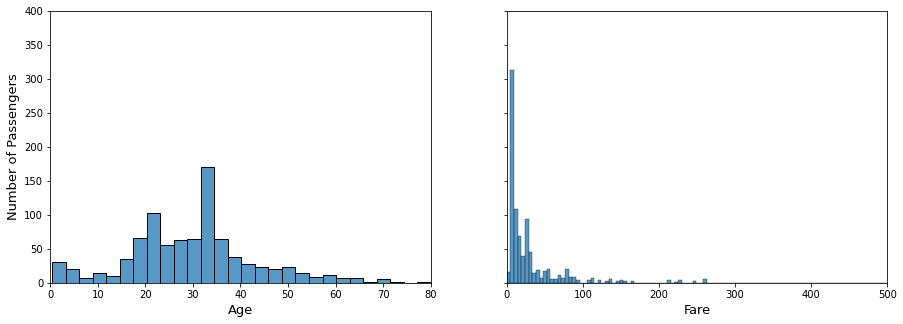

In [184]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharey=True)

sns.histplot(train_data['Age'],ax=ax1)
ax1.set_xlim([0,80])
ax1.set_ylim([0,400])
ax1.set_xlabel('Age',fontdict={'fontsize':13})
ax1.set_ylabel('Number of Passengers',fontdict={'fontsize':13})

sns.histplot(train_data['Fare'],ax=ax2)
ax2.set_xlim([0,500])
ax2.set_xlabel('Fare',fontdict={'fontsize':13})

plt.show()

# from chart most people paid less than 100 usd for this trip and concentration of age in 20 to 40 mark

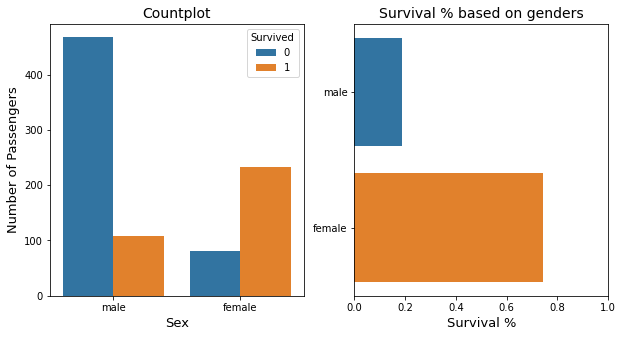

In [185]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='Sex',data=train_data,hue='Survived',ax=ax1)
ax1.set_xlabel('Sex',fontdict={'fontsize':13})
ax1.set_ylabel('Number of Passengers',fontdict={'fontsize':13})
ax1.set_title('Countplot',fontdict={'fontsize':14})

sns.barplot(x='Survived',y='Sex',data=train_data,errwidth=0,ax=ax2)
ax2.set_xlim([0,1])
ax2.set_xlabel('Survival %',fontdict={'fontsize':13})
ax2.set_ylabel('',fontdict={'fontsize':13})
ax2.set_title('Survival % based on genders',fontdict={'fontsize':14})

plt.show()

# seen that majority of passengers are male but survival rate is in favour of females

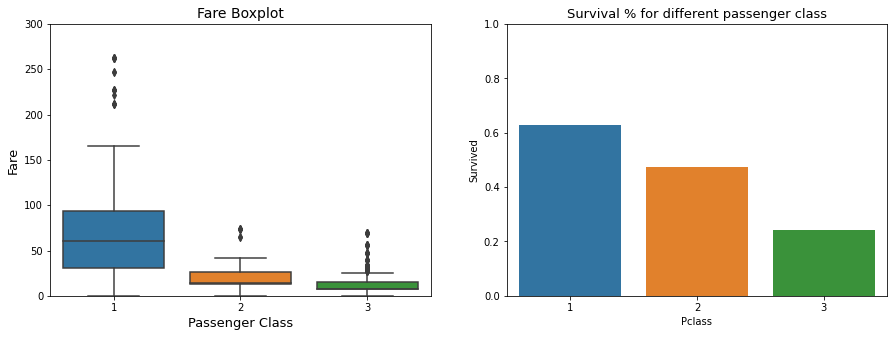

In [186]:
# we know Fare is supposed to affect Pclass, but let's confirm via EDA
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharex=True)

sns.boxplot(x='Pclass',y='Fare',data=train_data,ax=ax1)
ax1.set_ylim([0,300])
ax1.set_xlabel('Passenger Class',fontdict={'fontsize':13})
ax1.set_ylabel('Fare',fontdict={'fontsize':13})
ax1.set_title('Fare Boxplot',fontdict={'fontsize':14})

sns.barplot(x='Pclass',y='Survived',data=train_data,errwidth=0,ax=ax2)
ax2.set_ylim([0,1])
ax2.set_title('Survival % for different passenger class',fontdict={'fontsize':13})

plt.show()

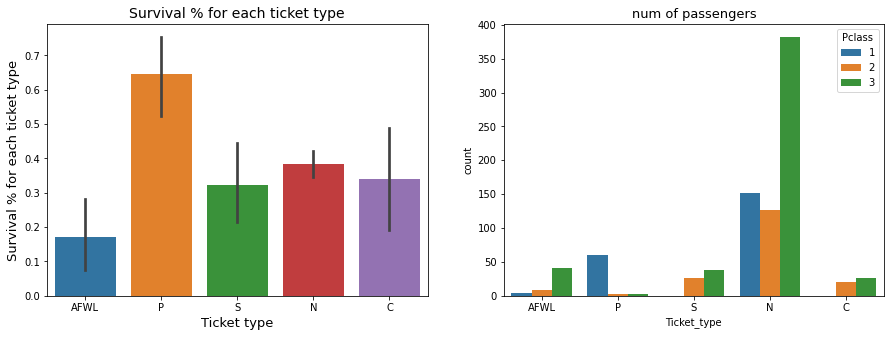

In [187]:
# relationship between ticket type and Survival, lets see
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharex=True)

sns.barplot(x='Ticket_type',y='Survived',data=train_data,ax=ax1)

ax1.set_xlabel('Ticket type',fontdict={'fontsize':13})
ax1.set_ylabel('Survival % for each ticket type',fontdict={'fontsize':13})
ax1.set_title('Survival % for each ticket type',fontdict={'fontsize':14})

sns.countplot(x='Ticket_type', data=train_data,ax=ax2, hue="Pclass")
ax2.set_title('num of passengers',fontdict={'fontsize':13})

plt.show()

# seems most expensive ticket type is P type since higher survival rate and also most of it's buys are first class candidates
# leading to ticket type also contributing to whether class_1 customer will survive

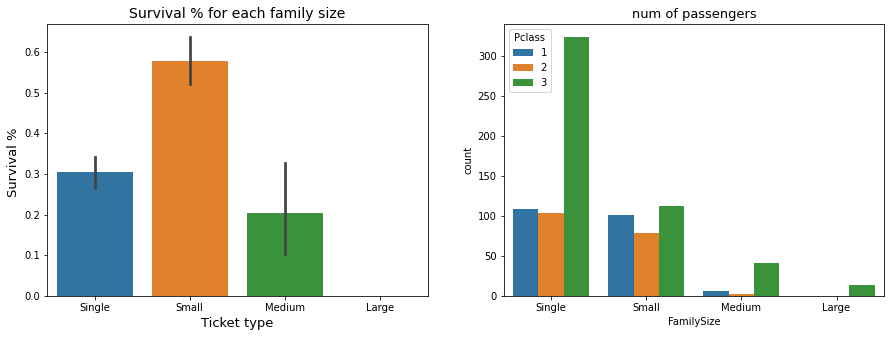

In [188]:
# View how family Size affects survival rate

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharex=True)

sns.barplot(x='FamilySize',y='Survived',data=train_data,ax=ax1)

ax1.set_xlabel('Ticket type',fontdict={'fontsize':13})
ax1.set_ylabel('Survival % ',fontdict={'fontsize':13})
ax1.set_title('Survival % for each family size',fontdict={'fontsize':14})

sns.countplot(x='FamilySize', data=train_data,ax=ax2, hue="Pclass")
ax2.set_title('num of passengers',fontdict={'fontsize':13})

plt.show()

# people in small and single size families had better chance of survival, while those in large family stood no chance of survival

## Clean Test Data And Extract Similar Features as we did Train data

In [196]:
test_data= test_df.copy()

# gets the title
test_data["Title"] = test_data["Name"].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [197]:
# impute missing age values if any
test_data["Age"] = test_data["Age"].fillna(test_data.groupby(["Title", "Sex"])["Age"].transform("mean"))

In [198]:
# Extract Ticket type feature
otherwise = test_data["Ticket"].str.split(" ").str.get(0).str.get(0)  # gets the first char
test_data["Ticket_type"] = np.where(test_data["Ticket"].str.isdigit(), "N", otherwise)

test_data["Ticket_type"] = test_data["Ticket_type"].apply(lambda x: "AFWL" if x in "AFWL" else x)

test_data["Ticket_type"].value_counts()

N       296
S        33
P        33
C        30
AFWL     26
Name: Ticket_type, dtype: int64

In [199]:
# seen that Fare, Age and Cabin col has nan
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              1
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
Ticket_type      0
dtype: int64

In [200]:
# for Fare, we know passengers fare is depenedent on pclass.. so used in filling Fare
test_data["Fare"].fillna(test_data.groupby("Pclass")["Fare"].transform("mean"), inplace=True)

In [201]:
# inpute missing nan for Age
test_data["Age"] = test_data["Age"].fillna(test_data.groupby(["Title", "Sex"])["Age"].transform("mean"))

In [202]:
# get the familySize 
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"] + 1
test_data["FamilySize"] = pd.cut(test_data["FamilySize"], bins = [0, 1, 4, 7, 150],
                                  labels = ["Single", "Small", "Medium", "Large"])

test_data["FamilySize"].unique()

['Single', 'Small', 'Medium', 'Large']
Categories (4, object): ['Single' < 'Small' < 'Medium' < 'Large']

In [205]:
# drop the needed col
test_data = drop_column(test_data, ["PassengerId", "Name", "Ticket", "Cabin"])

test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_type,FamilySize
0,3,male,34.5,0,0,7.8292,Q,Mr,N,Single
1,3,female,47.0,1,0,7.0000,S,Mrs,N,Small
2,2,male,62.0,0,0,9.6875,Q,Mr,N,Single
3,3,male,27.0,0,0,8.6625,S,Mr,N,Single
4,3,female,22.0,1,1,12.2875,S,Mrs,N,Small


In [206]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_type,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,Mr,AFWL,Small
1,1,1,female,38.0,1,0,71.2833,C,Mrs,P,Small
2,1,3,female,26.0,0,0,7.9250,S,Miss,S,Single
3,1,1,female,35.0,1,0,53.1000,S,Mrs,N,Small
4,0,3,male,35.0,0,0,8.0500,S,Mr,N,Single


### Data Processing Process to set up data for model Building

In [225]:
y_train = train_data["Survived"]

x_train = train_data.drop(["Survived", "Title", "SibSp", "Parch"], axis = 1)
x_test = test_data.drop(["Title","SibSp", "Parch" ], axis = 1)

x_train.head()

,Pclass,Sex,Age,Fare,Embarked,Ticket_type,FamilySize
0,3,male,22.0,7.2500,S,AFWL,Small
1,1,female,38.0,71.2833,C,P,Small
2,3,female,26.0,7.9250,S,S,Single
3,1,female,35.0,53.1000,S,N,Small
4,3,male,35.0,8.0500,S,N,Single


In [226]:
# Column Transformer which does one hot encoding of need col at one shot, life saver
from sklearn.compose import ColumnTransformer

col_transformer = ColumnTransformer([
    # index col to encode 
    ("encoder", OneHotEncoder(sparse = False, handle_unknown ="ignore"), [0, 1, 4, 5, 6]),
], remainder ="passthrough", verbose_feature_names_out=False)

In [227]:
x_train = col_transformer.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = col_transformer.get_feature_names_out())

x_test = col_transformer.fit_transform(x_test)
x_test = pd.DataFrame(x_test, columns = col_transformer.get_feature_names_out())


x_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_type_AFWL,Ticket_type_C,Ticket_type_N,Ticket_type_P,Ticket_type_S,FamilySize_Large,FamilySize_Medium,FamilySize_Single,FamilySize_Small,Age,Fare
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,7.2500
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,38.0,71.2833
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,26.0,7.9250
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,35.0,53.1000
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,35.0,8.0500


In [228]:
# standardize numerical features
num_col = ["Age", "Fare"]
min_scaler = RobustScaler()


x_train_scaled = min_scaler.fit_transform(x_train[num_col])
x_train_scaled = pd.DataFrame(x_train_scaled, columns = num_col)
x_train_scaled = pd.concat([x_train.drop(num_col, axis = 1), x_train_scaled], axis = 1)

x_train_scaled.head(4)

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_type_AFWL,Ticket_type_C,Ticket_type_N,Ticket_type_P,Ticket_type_S,FamilySize_Large,FamilySize_Medium,FamilySize_Single,FamilySize_Small,Age,Fare
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.566405,-0.312011
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.566405,2.461242
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.283202,-0.282777
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.354003,1.673732


In [229]:
x_test_scaled = min_scaler.fit_transform(x_test[num_col])
x_test_scaled = pd.DataFrame(x_test_scaled, columns = num_col)
x_test_scaled = pd.concat([x_test.drop(num_col, axis = 1), x_test_scaled], axis = 1)

x_test_scaled.head(4)

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_type_AFWL,Ticket_type_C,Ticket_type_N,Ticket_type_P,Ticket_type_S,FamilySize_Large,FamilySize_Medium,FamilySize_Single,FamilySize_Small,Age,Fare
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.302521,-0.281005
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.142857,-0.316176
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.151261,-0.202184
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.201681,-0.245660


### Model Building and Evalution

In [214]:
from sklearn.model_selection import cross_val_score


# x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_, test_size = 0.1)

random_trees = RandomForestClassifier(n_estimators = 600, max_depth= 7,
                                      random_state=100, n_jobs = -1,)

random_trees.fit(x_train_scaled, y_train)
# random_trees.score(x_val, y_val)

cross_val_score(random_trees, x_train_scaled, y_train, cv = 5).mean()

# base line is this : [0.84916201, 0.82022472, 0.85955056, 0.79213483, 0.86516854]

0.82045069361622

In [234]:
# Voting clf
from sklearn.svm import SVC

estimators = []

estimators.append(("rf1", RandomForestClassifier(n_estimators = 400, max_depth= 7,
                                       n_jobs = -1)))
estimators.append(("rf2", RandomForestClassifier(n_estimators = 600, max_depth= 6,
                                       n_jobs = -1,)))
estimators.append(("xgb", XGBClassifier(learning_rate = 0.4, n_estimators = 1000,)))
estimators.append(("xgb2", XGBClassifier(learning_rate = 0.5, n_estimators = 900)))
estimators.append(("svc",  SVC(C=100,gamma=0.01)))

ensemble = VotingClassifier(estimators = estimators, voting = "hard")
ensemble.fit(x_train_scaled, y_train)
cross_val_score(ensemble, x_train_scaled, y_train, cv = 5).mean()



0.8305567760969179

In [235]:
predictions = ensemble.predict(x_test_scaled)

In [242]:
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": predictions
})

submission.to_csv("sumission_2.csv", index= False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
